# Single Experiment

In this notebook we run a single experiment and display the estimates of the dynamic effects based on our dynamic DML algorithm. We also display some performance of alternative benchmark approaches.

## 1. Data Generation from a Markovian Treatment Model

We consider the following DGP:

\begin{align}
    X_t =& (\pi'X_{t-1} + 1) \cdot A\, T_{t-1} + B X_{t-1} + \epsilon_t\\
    T_t =& \gamma\, T_{t-1} + (1-\gamma) \cdot D X_t + \zeta_t\\
    Y_t =& (\sigma' X_{t} + 1) \cdot e\, T_{t} + f' X_t + \eta_t
\end{align}

with $X_0, T_0 = 0$ and $\epsilon_t, \zeta_t, \eta_t$ normal $N(0, \sigma^2)$ r.v.'s. Moreover, $X_t \in R^{n_x}$, $B[:, 0:s_x] \neq 0$ and $B[:, s_x:-1] = 0$, $\gamma\in [0, 1]$, $D[:, 0:s_x] \neq 0$, $D[:, s_x:-1]=0$, $f[0:s_x]\neq 0$, $f[s_x:-1]=0$. We draw a single time series of samples of length $n\_samples$.

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
from dynamic_panel_dgp import DynamicPanelDGP, LongRangeDynamicPanelDGP
n_units = 400
n_periods = 3
n_treatments = 1
n_x = 100
s_x = 10
s_t = 10
sigma_x = .5
sigma_t = .5
sigma_y = .5
gamma = .0
autoreg = .5
state_effect = .5
conf_str = 6
hetero_strength = 0
hetero_inds = None

#dgp_class = LongRangeDynamicPanelDGP
dgp_class = DynamicPanelDGP
dgp = dgp_class(n_periods, n_treatments, n_x).create_instance(s_x, sigma_x, sigma_y,
                                                              conf_str, hetero_strength, hetero_inds,
                                                              autoreg, state_effect,
                                                              random_seed=39)

C:\ProgramData\Anaconda3\lib\site-packages\numba\errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
Y, T, X, groups = dgp.observational_data(n_units, gamma, s_t, sigma_t, random_seed=1234)
true_effect = dgp.true_effect

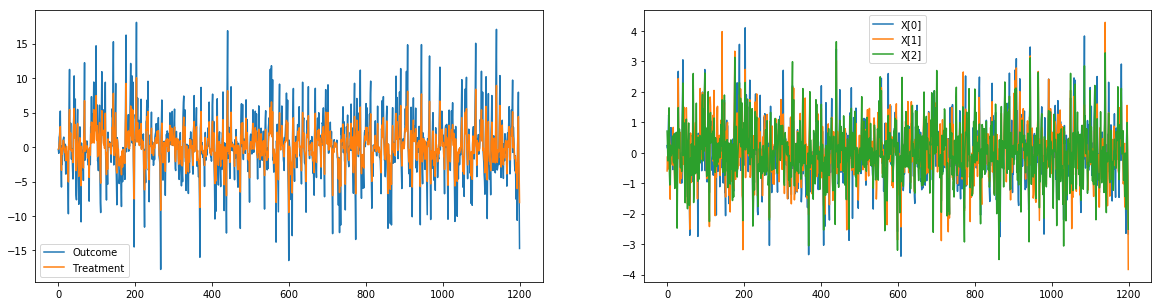

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(Y, label="Outcome")
plt.plot(T, label="Treatment")
plt.legend()
plt.subplot(1, 2, 2)
for it in range(3):
    plt.plot(X[:, it], label="X[{}]".format(it))
plt.legend()
plt.show()

### 1. 1 True Parameters for Dynamic Effects for 3 periods

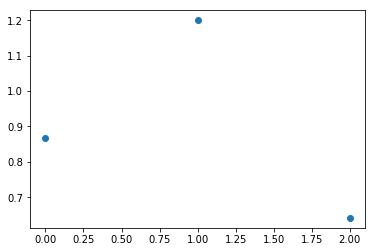

In [4]:
import matplotlib.pyplot as plt

true_effect = true_effect.flatten()
plt.plot(true_effect, 'o')
plt.show()

## 2. Dynamic DML

In [5]:
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, MultiTaskLasso, MultiTaskLassoCV
from sklearn.model_selection import GroupKFold
import warnings
warnings.simplefilter('ignore')

np.random.seed(123)

alpha_regs = [1e-4, 1e-3, 1e-2, 5e-2, .1, 1]
lasso_model = lambda : LassoCV(cv=3, alphas=alpha_regs, max_iter=500)
mlasso_model = lambda : MultiTaskLassoCV(cv=3, alphas=alpha_regs, max_iter=500)

In [6]:
from panel_dynamic_dml import DynamicPanelDML

est = DynamicPanelDML(model_t=mlasso_model(),
                      model_y=lasso_model(),
                      n_cfit_splits=3).fit(Y, T, X, groups)

### 2.1 Parameter Recovery and Confidence Intervals

In [7]:
param_hat = est.param
conf_ints = est.param_interval(alpha=.05)
for kappa in range(n_periods):
    for t in range(n_treatments):
        param_ind = kappa*n_treatments + t
        print("Effect Lag={}, T={}: {:.3f} ({:.3f}, {:.6f}), (Truth={:.6f})".format(kappa, t,
                                                                                    param_hat[param_ind],
                                                                                    *conf_ints[param_ind],
                                                                                    true_effect[param_ind]))

Effect Lag=0, T=0: 0.777 (0.687, 0.868074), (Truth=0.866165)
Effect Lag=1, T=0: 1.147 (0.919, 1.375321), (Truth=1.200000)
Effect Lag=2, T=0: 0.896 (0.536, 1.257250), (Truth=0.641424)


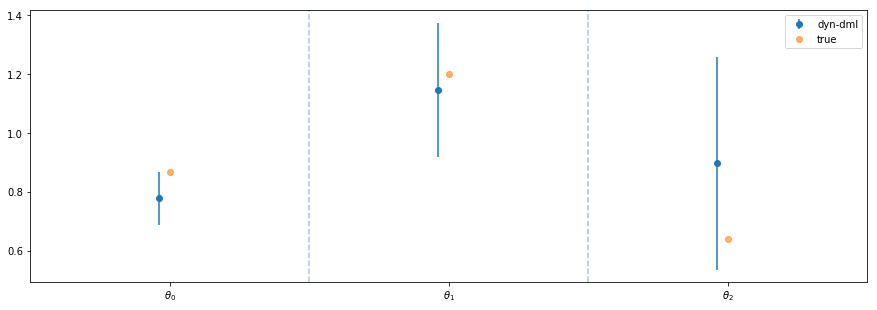

In [8]:
plt.figure(figsize=(15, 5))
plt.errorbar(np.arange(n_periods*n_treatments)-.04, param_hat, yerr=(conf_ints[:, 1] - param_hat,
                                                    param_hat - conf_ints[:, 0]), fmt='o', label='dyn-dml')
plt.errorbar(np.arange(n_periods*n_treatments), true_effect.flatten(), fmt='o', alpha=.6, label='true')
for t in np.arange(1, n_periods):
    plt.axvline(x=t * n_treatments - .5, linestyle='--', alpha=.4)
plt.xticks([t * n_treatments - .5 + n_treatments/2 for t in range(n_periods)],
           ["$\\theta_{}$".format(t) for t in range(n_periods)])
plt.gca().set_xlim([-.5, n_periods*n_treatments - .5])
plt.legend()
plt.show()

### 2.2 Benchmark Method Comparison

In [9]:
panelX = X.reshape(-1, n_periods, n_x)
panelT = T.reshape(-1, n_periods, n_treatments)
panelY = Y.reshape(-1, n_periods)

#### 2.2.1 Regressing Y on all T

In [10]:
est_lr = LinearRegression().fit(panelT[:, ::-1, :].reshape(-1, n_periods*n_treatments), panelY[:, -1]).coef_

#### 2.2.2 Regressing Y on all T and either final or initial States

In [11]:
est_lr_x0 = lasso_model().fit(np.hstack([panelT[:, ::-1, :].reshape(-1, n_periods*n_treatments),
                                  panelX[:, 0, :]]), panelY[:, -1]).coef_[:n_periods*n_treatments]
est_lr_xfinal = lasso_model().fit(np.hstack([panelT[:, ::-1, :].reshape(-1, n_periods*n_treatments),
                                  panelX[:, -1, :]]), panelY[:, -1]).coef_[:n_periods*n_treatments]

#### 2.2.3 Performing DML with Y and all T and controlling for either final or initial States

In [12]:
from econml.dml import LinearDMLCateEstimator
dml_model = lambda : LinearDMLCateEstimator(model_y=lasso_model(), model_t=mlasso_model(),
                                      n_splits=3, linear_first_stages=False)
est_dml_x0 = dml_model().fit(panelY[:, -1], T=panelT[:, ::-1, :].reshape(-1, n_periods*n_treatments),
                      X=None, W=panelX[:, 0, :]).intercept_
est_dml_xfinal = dml_model().fit(panelY[:, -1], T=panelT[:, ::-1, :].reshape(-1, n_periods*n_treatments),
                      X=None, W=panelX[:, -1, :]).intercept_

#### 2.2.4 Running a Direct version of Dynamic DML

Where a direct lasso is performed at each stage, regressing the calibrated outcome on the current period treatment and state and reading the coefficient in front of the treatment as the causal effect.

In [13]:
Y_cal = panelY[:, -1].copy()
direct_theta = np.zeros((n_periods, n_treatments))
for t in np.arange(n_periods):
    direct_theta[t, :] = lasso_model().fit(np.hstack([panelT[:, n_periods - 1 - t, :],
                                                      panelX[:, n_periods - 1 - t, :]]), Y_cal).coef_[:n_treatments]
    Y_cal -= np.dot(panelT[:, n_periods - 1 - t, :], direct_theta[t, :])
est_direct = direct_theta.flatten()

#### 2.2.5 Plot all estimates

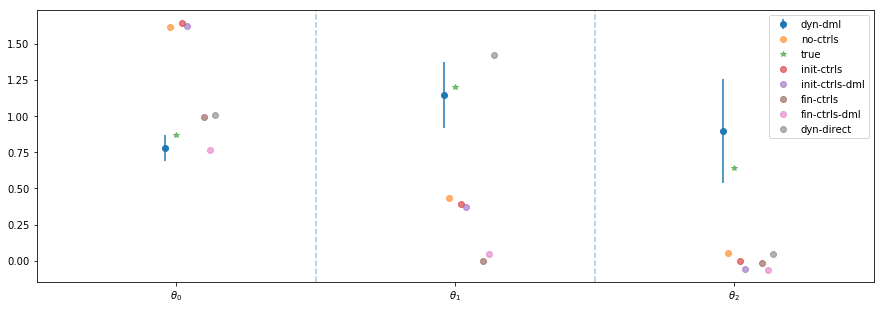

In [14]:
plt.figure(figsize=(15, 5))
plt.errorbar(np.arange(n_periods*n_treatments)-.04, param_hat, yerr=(conf_ints[:, 1] - param_hat,
                                                    param_hat - conf_ints[:, 0]), fmt='o', label='dyn-dml')
plt.errorbar(np.arange(n_periods*n_treatments)-.02, est_lr, fmt='o', alpha=.6, label='no-ctrls')
plt.errorbar(np.arange(n_periods*n_treatments), true_effect.flatten(), fmt='*', alpha=.6, label='true')
plt.errorbar(np.arange(n_periods*n_treatments)+.02, est_lr_x0, fmt='o', alpha=.6, label='init-ctrls')
plt.errorbar(np.arange(n_periods*n_treatments)+.04, est_dml_x0, fmt='o', alpha=.6, label='init-ctrls-dml')
plt.errorbar(np.arange(n_periods*n_treatments)+.1, est_lr_xfinal, fmt='o', alpha=.6, label='fin-ctrls')
plt.errorbar(np.arange(n_periods*n_treatments)+.12, est_dml_xfinal, fmt='o', alpha=.6, label='fin-ctrls-dml')
plt.errorbar(np.arange(n_periods*n_treatments)+.14, est_direct, fmt='o', alpha=.6, label='dyn-direct')
for t in np.arange(1, n_periods):
    plt.axvline(x=t * n_treatments - .5, linestyle='--', alpha=.4)
plt.xticks([t * n_treatments - .5 + n_treatments/2 for t in range(n_periods)],
           ["$\\theta_{}$".format(t) for t in range(n_periods)])
plt.gca().set_xlim([-.5, n_periods*n_treatments - .5])
plt.legend()
plt.show()

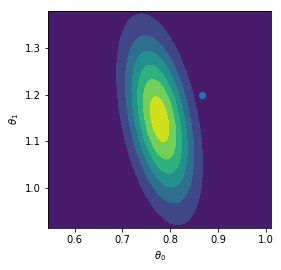

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

id1, id2 = 0, 1
length = 2 * max(est.param_stderr[id1], est.param_stderr[id2])
xlin = np.linspace(param_hat[id1]-length, param_hat[id1] + length, 500)
ylin = np.linspace(param_hat[id2]-length, param_hat[id2] + length, 500)
grX,grY = np.meshgrid(xlin, ylin)
pos = np.array([grX.flatten(), grY.flatten()]).T

rv = multivariate_normal(param_hat[[id1,id2]], est._cov[np.ix_([id1, id2], [id1, id2])]/n_units)

fig = plt.figure(figsize=(4,4))
ax0 = fig.add_subplot(111)
ax0.contourf(grX, grY, rv.pdf(pos).reshape(500,500))
ax0.scatter(true_effect[id1], true_effect[id2])
plt.xlabel("$\\theta_{{{}}}$".format(id1))
plt.ylabel("$\\theta_{{{}}}$".format(id2))
plt.show()

## 3. Policy Effect

In [16]:
tau = np.random.binomial(1, .5, size=(n_periods, n_treatments))
true_policy_effect = dgp.static_policy_effect(tau, mc_samples=1000)
policy_effect_hat = est.policy_effect(tau)
policy_ints = est.policy_effect_interval(tau)
print("Policy effect for treatment seq: \n {}\n {:.3f} ({:.3f}, {:.3f}) (truth={:.3f})".format(tau,
                                                                                               policy_effect_hat,
                                                                                               *policy_ints,
                                                                                               true_policy_effect))

Policy effect for treatment seq: 
 [[0]
 [1]
 [0]]
 1.147 (0.919, 1.375) (truth=1.200)


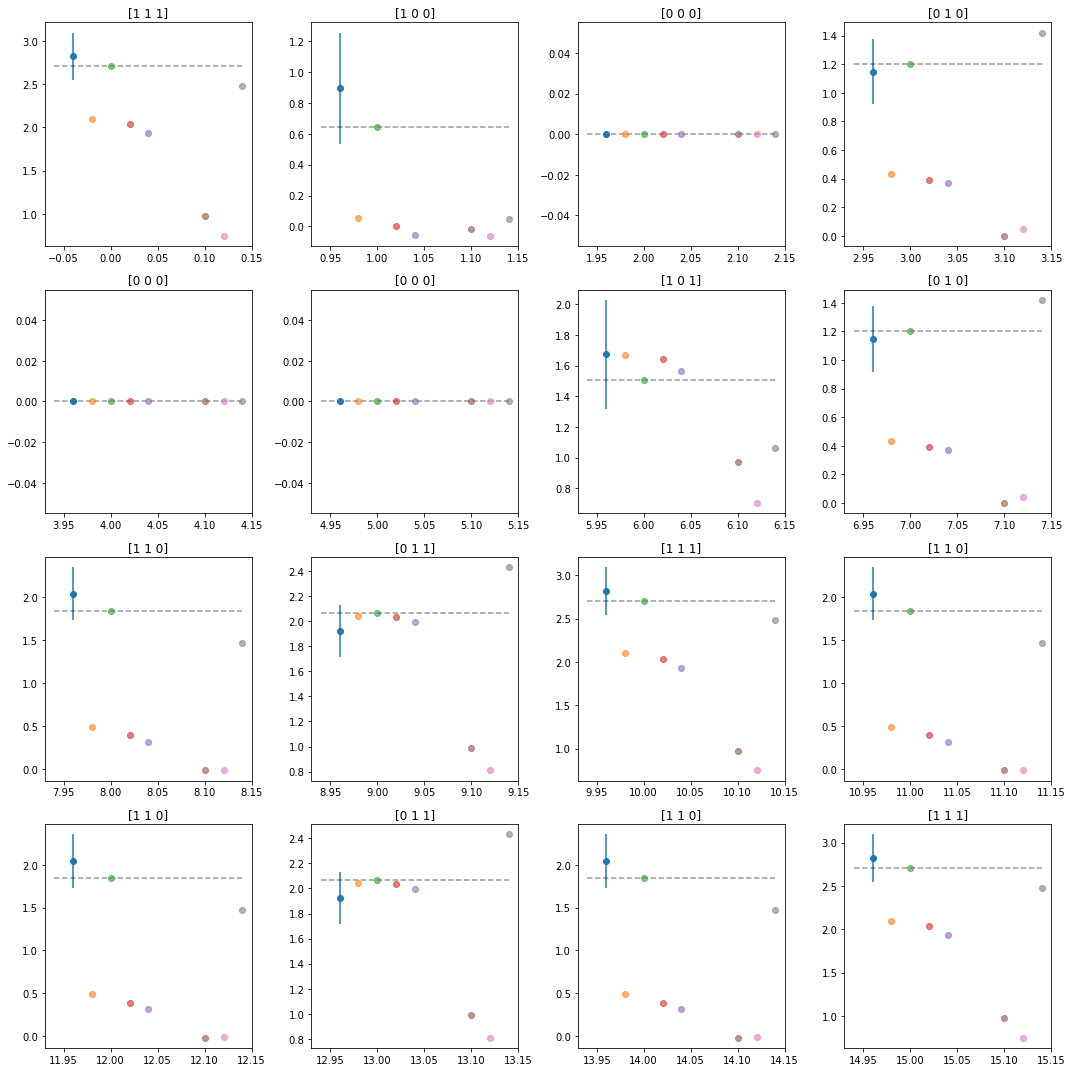

In [17]:
test_policies = np.random.binomial(1, .5, size=(16, n_periods, n_treatments))

plt.figure(figsize=(15, 15))
for t, tau in enumerate(test_policies):
    true_policy_effect = np.dot(true_effect, tau[::-1].flatten())
    policy_effect_hat = est.policy_effect(tau)
    policy_ints = est.policy_effect_interval(tau)
    plt.subplot(4, 4, t + 1)
    plt.errorbar([t -.04], [policy_effect_hat], yerr=([policy_ints[1] - policy_effect_hat],
                                                  [policy_effect_hat - policy_ints[0]]), fmt='o', label='dyn-dml')
    plt.errorbar([t -.02], [np.dot(est_lr, tau[::-1].flatten())], fmt='o', alpha=.6, label='no-ctrls')
    plt.errorbar([t], [true_policy_effect], fmt='o', alpha=.6, label='true')
    plt.hlines([true_policy_effect], t - .06, t + .14, linestyles='--', alpha=.4)
    plt.errorbar([t + .02], [np.dot(est_lr_x0, tau[::-1].flatten())], fmt='o', alpha=.6, label='init-ctrls')
    plt.errorbar([t + .04], [np.dot(est_dml_x0, tau[::-1].flatten())], fmt='o', alpha=.6, label='init-ctrls-dml')
    plt.errorbar([t + .1], [np.dot(est_lr_xfinal, tau[::-1].flatten())], fmt='o', alpha=.6, label='fin-ctrls')
    plt.errorbar([t + .12], [np.dot(est_dml_xfinal, tau[::-1].flatten())], fmt='o', alpha=.6, label='fin-ctrls-dml')
    plt.errorbar([t +.14], [np.dot(est_direct, tau[::-1].flatten())], fmt='o', alpha=.6, label='dyn-direct')
    plt.title("{}".format(tau.flatten()))
#plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Optimal Contextual Binary Treatment Policy
def adaptive_policy(t, x, period):
    return 1.*(dgp.hetero_effect_fn(n_periods - 1 - period, x) > 0)
dgp.adaptive_policy_effect(adaptive_policy)

2.707589092135044

In [19]:
est.adaptive_policy_effect(X, groups, adaptive_policy)

(2.820942109125225, (2.547666040491572, 3.094218177758878))

## 4. Estimation Diagnostics

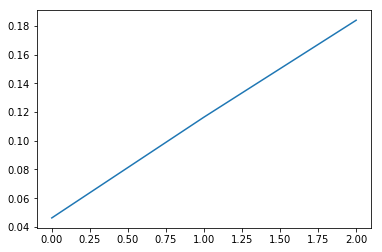

In [20]:
import matplotlib.pyplot as plt
plt.plot(est.param_stderr)
plt.show()

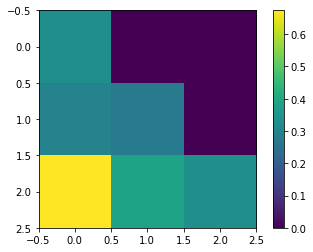

In [21]:
plt.imshow(est._M)
plt.colorbar()
plt.show()

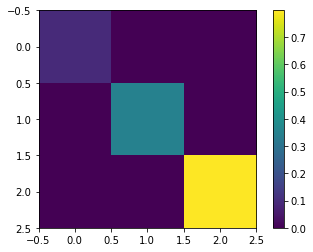

In [22]:
plt.imshow(est._Sigma)
plt.colorbar()
plt.show()

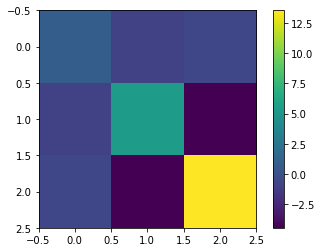

In [23]:
plt.imshow(est._cov)
plt.colorbar()
plt.show()